In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../data/sales_train.csv',  parse_dates= ['date'])
test = pd.read_csv('../data/sales_test.csv',  parse_dates= ['date'])

calendar = pd.read_csv('../data/calendar.csv',  parse_dates= ['date'])
inventory = pd.read_csv('../data/inventory.csv')
solution = pd.read_csv('../data/solution.csv')
weights = pd.read_csv('../data/test_weights.csv')

files = {
    "train": train,
    "test": test,
    "calendar": calendar,
    "inventory": inventory,
    "solution": solution,
    "weights": weights
}

### data 총정리

#### 파일
|  | sales_train.csv | sales_test.csv | inventory.csv | calendar.csv | test_weights.csv |
|---------------------------------------|-----------------|----------------|---------------|--------------|------------------|
| unique_id | O | O | O | X | O |
| date | O | O | X | O | X |
| warehouse | O | O | O | O | X |
| total_orders | O | O | X | X | X |
| sales(목표값) | O | X | X | X | X |
| sell_price_main | O | O | X | X | X |
| availability | O | X | X | X | X |
| type_0_discount, type_1_discount, … | O | O | X | X | X |
| product_unique_id | X | X | O | X | X |
| name(물건_no) | X | X | O | X | X |
| L1_category_name, L2_category_name, … | X | X | O | X | X |
| holiday_name | X | X | X | O | X |
| holiday | X | X | X | O | X |
| shops_closed | X | X | X | O | X |
| winter_school_holidays | X | X | X | O | X |
| school_holidays | X | X | X | O | X |
| weight | X | X | X | X | O |



------------
sales_train, sales_test - 
inventory - 제품의 재고와 같은 추가 정보 존재
calendar - 휴일 및 창고별 이벤트가 추가로 포함된 데이터셋
test_weights




## sales_train data

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype         
---  ------           -----         
 0   unique_id        int64         
 1   date             datetime64[ns]
 2   warehouse        object        
 3   total_orders     float64       
 4   sales            float64       
 5   sell_price_main  float64       
 6   availability     float64       
 7   type_0_discount  float64       
 8   type_1_discount  float64       
 9   type_2_discount  float64       
 10  type_3_discount  float64       
 11  type_4_discount  float64       
 12  type_5_discount  float64       
 13  type_6_discount  float64       
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 428.0+ MB


In [3]:
train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


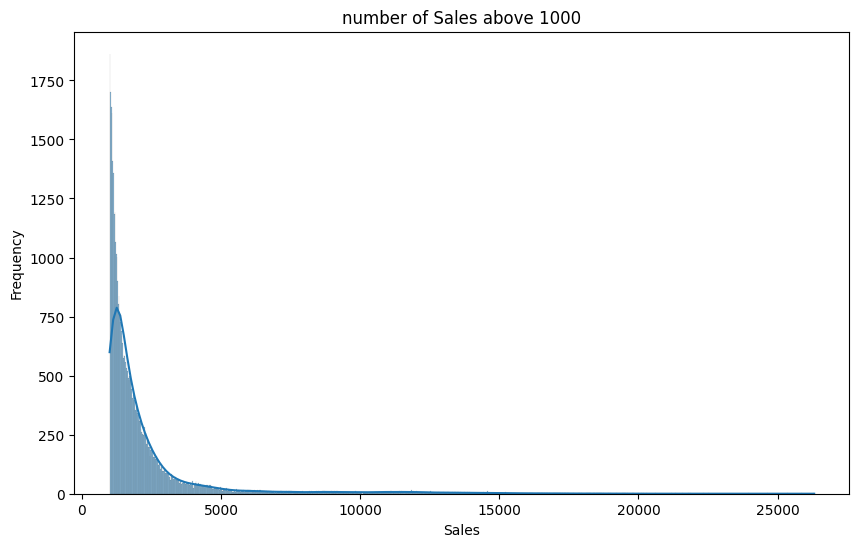

1000 이하 갯수: 45043
null 갯수: 52


In [4]:
sales_1000 = train[train['sales'] > 1000]['sales'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(sales_1000, bins=1000, kde=True)
plt.title('number of Sales above 1000')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

zero_count = train[train['sales'] >= 1000].shape[0]
print(f"1000 이하 갯수: {zero_count}")
sales_null_count = train['sales'].isnull().sum()
print(f"null 갯수: {sales_null_count}")

## 휴일 관련 정보 추가

In [5]:
Frankfurt_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Frankfurt_1"')
Prague_2 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_2"')
Brno_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Brno_1"')
Munich_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Munich_1"')
Prague_3 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_3"')
Prague_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_1"')
Budapest_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Budapest_1"')

def process_calendar(df):
    df = df.sort_values('date').reset_index(drop=True)
    
    # 1. days_to_holiday
    df['next_holiday_date'] = df.loc[df['holiday'] == 1, 'date'].shift(-1)
    df['next_holiday_date'] = df['next_holiday_date'].bfill()
    df['days_to_holiday'] = (df['next_holiday_date'] - df['date']).dt.days
    df.drop(columns=['next_holiday_date'], inplace=True)
    
    # 2. days_to_shops_closed
    df['next_shops_closed_date'] = df.loc[df['shops_closed'] == 1, 'date'].shift(-1)
    df['next_shops_closed_date'] = df['next_shops_closed_date'].bfill()
    df['days_to_shops_closed'] = (df['next_shops_closed_date'] - df['date']).dt.days
    df.drop(columns=['next_shops_closed_date'], inplace=True)
    
    # 3. day_after_closing
    df['day_after_closing'] = (
        (df['shops_closed'] == 0) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)
    
    # 4. long_weekend
    df['long_weekend'] = (
        (df['shops_closed'] == 1) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)
    
    # 5. weekday
    df['weekday'] = df['date'].dt.weekday  # 0 (понедельник) - 6 (воскресенье)
    
    return df


# Список датафреймов
dfs = ['Frankfurt_1', 'Prague_2', 'Brno_1', 'Munich_1', 'Prague_3', 'Prague_1', 'Budapest_1']

# Применяем функцию ко всем датафреймам и собираем их в список
processed_dfs = [process_calendar(globals()[df]) for df in dfs]

# Конкатенируем все датафреймы в один
calendar_extended = pd.concat(processed_dfs).sort_values('date').reset_index(drop=True)

In [6]:
train = train.merge(calendar_extended,on=['warehouse','date'],how='left') 
train = train.merge(inventory,on=['warehouse','unique_id'],how='left')

test = test.merge(calendar_extended,on=['warehouse','date'],how='left')
test = test.merge(inventory,on=['warehouse','unique_id'],how='left')

In [7]:
train.sample(10).T

,1126183,2217733,677342,2400019,3532546,1168981,4004326,3993326,1206720,2376125
unique_id,2813,3140,2872,700,1202,798,3231,673,18,448
date,2024-02-08 00:00:00,2021-11-07 00:00:00,2020-11-16 00:00:00,2024-04-12 00:00:00,2022-04-18 00:00:00,2022-11-12 00:00:00,2022-06-07 00:00:00,2022-06-05 00:00:00,2022-06-30 00:00:00,2023-04-17 00:00:00
warehouse,Prague_3,Prague_1,Brno_1,Prague_1,Prague_1,Budapest_1,Frankfurt_1,Munich_1,Prague_1,Prague_3
total_orders,5537.0,9008.0,7586.0,12008.0,8473.0,5307.0,1305.0,763.0,8472.0,5689.0
sales,23.29,10.84,218.04,32.65,91.5,96.07,30.06,71.53,54.91,149.69
sell_price_main,29.14,79.85,93.43,14.47,71.41,963.39,6.29,5.11,33.38,47.23
availability,1.0,1.0,1.0,1.0,0.55,0.78,1.0,1.0,1.0,0.76
type_0_discount,0.0,0.0,0.0,0.0,0.0,0.42519,0.0,0.04345,0.0,0.0
type_1_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
type_2_discount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
days_to_holiday                 0
days_to_shops_closed            0
day_after_closing               0
long_weekend                    0
weekday                         0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_na

In [9]:
train = train.dropna(subset=['sales'])
train.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                    0
sales                           0
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
holiday_name              3844077
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
days_to_holiday                 0
days_to_shops_closed            0
day_after_closing               0
long_weekend                    0
weekday                         0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_na

## 가격에 따른 판매

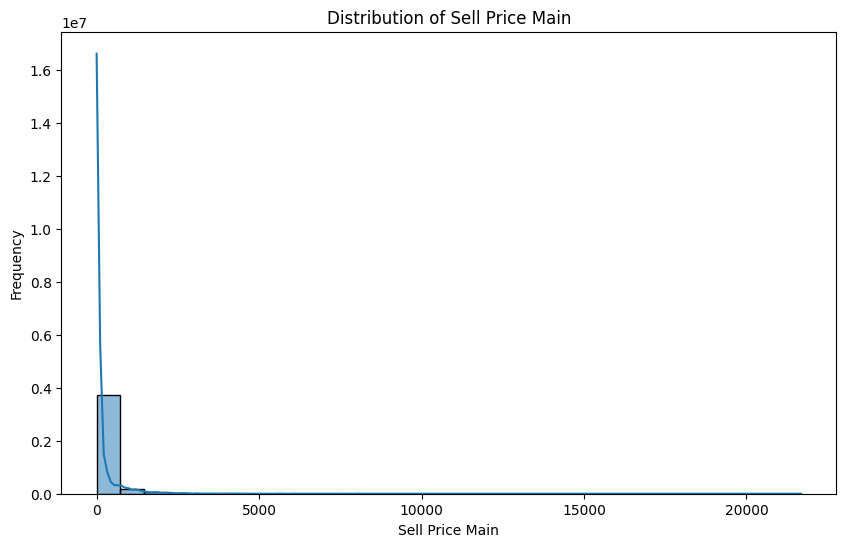

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(train['sell_price_main'], bins=30, kde=True)
plt.title('Distribution of Sell Price Main')
plt.xlabel('Sell Price Main')
plt.ylabel('Frequency')
plt.show()

In [11]:
price_5 = train[train['sell_price_main'] <= 5]
price_5_50 = train[(train['sell_price_main'] > 5) & (train['sell_price_main'] <= 50)]
price_50_100 = train[(train['sell_price_main'] > 50) & (train['sell_price_main'] <= 100)]
price_100_300 = train[(train['sell_price_main'] > 100) & (train['sell_price_main'] <= 300)]
price_300_700 = train[(train['sell_price_main'] > 300) & (train['sell_price_main'] <= 700)]
price_700_1000 = train[(train['sell_price_main'] > 700) & (train['sell_price_main'] <= 1000)]
price_above_1000 = train[train['sell_price_main'] > 1000]

print(price_5.shape[0],price_5_50.shape[0],price_50_100.shape[0],price_100_300.shape[0],price_300_700.shape[0],price_700_1000.shape[0],price_above_1000.shape[0])

439135 1706501 770938 556548 247831 108004 178410


In [12]:
price_5.head()


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,days_to_shops_closed,day_after_closing,long_weekend,weekday,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en
11785,3507,2022-01-04,Prague_2,5037.0,78.17,4.35,1.00,0.0,0.0,0.0,...,124.0,0,0,1,1721,Roll_36,Bakery,Bakery_L2_7,Bakery_L3_51,Bakery_L4_1
11786,3507,2021-03-08,Prague_2,4565.0,118.00,3.47,0.79,0.0,0.0,0.0,...,61.0,0,0,0,1721,Roll_36,Bakery,Bakery_L2_7,Bakery_L3_51,Bakery_L4_1
11787,3507,2021-03-01,Prague_2,3815.0,102.44,3.47,1.00,0.0,0.0,0.0,...,68.0,0,0,0,1721,Roll_36,Bakery,Bakery_L2_7,Bakery_L3_51,Bakery_L4_1
11791,3507,2020-11-11,Prague_2,3731.0,111.87,3.47,0.42,0.0,0.0,0.0,...,45.0,0,0,2,1721,Roll_36,Bakery,Bakery_L2_7,Bakery_L3_51,Bakery_L4_1
11793,3507,2021-11-15,Prague_2,4756.0,144.32,3.47,0.70,0.0,0.0,0.0,...,41.0,0,0,0,1721,Roll_36,Bakery,Bakery_L2_7,Bakery_L3_51,Bakery_L4_1


In [13]:
print(price_5['sales'].mean(),price_5_50['sales'].mean(),price_50_100['sales'].mean(),price_100_300['sales'].mean(),price_300_700['sales'].mean(),price_700_1000['sales'].mean(),price_above_1000['sales'].mean())

223.5919928268072 116.73509883674255 78.13444753015158 64.51257444101854 86.09699117543809 79.85756490500351 60.65927778711958


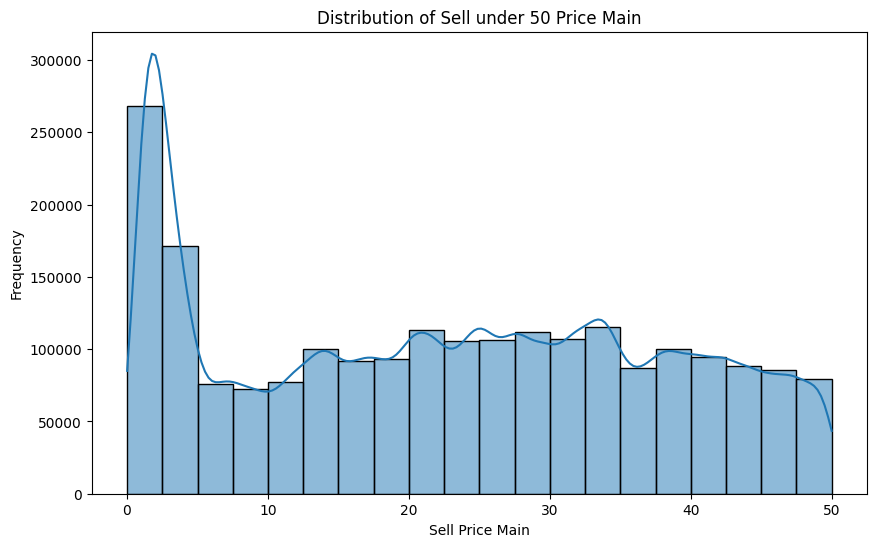

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(train[(train['sell_price_main'] <= 50)]['sell_price_main'], bins=20, kde=True)
plt.title('Distribution of Sell under 50 Price Main')
plt.xlabel('Sell Price Main')
plt.ylabel('Frequency')
plt.show()

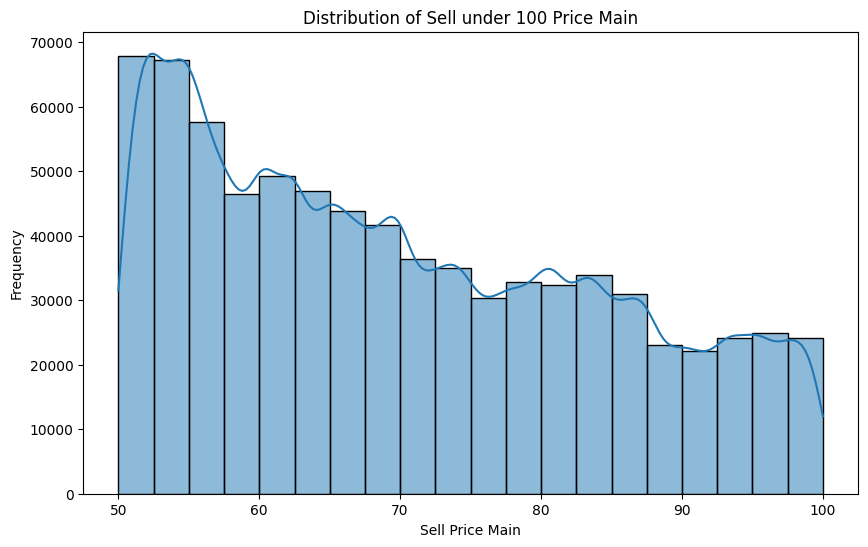

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(price_50_100['sell_price_main'], bins=20, kde=True)
plt.title('Distribution of Sell under 100 Price Main')
plt.xlabel('Sell Price Main')
plt.ylabel('Frequency')
plt.show()

5이하, 50이하, 100이하, 300이하, 700이하, 700이상으로 나눠볼것

## holiday

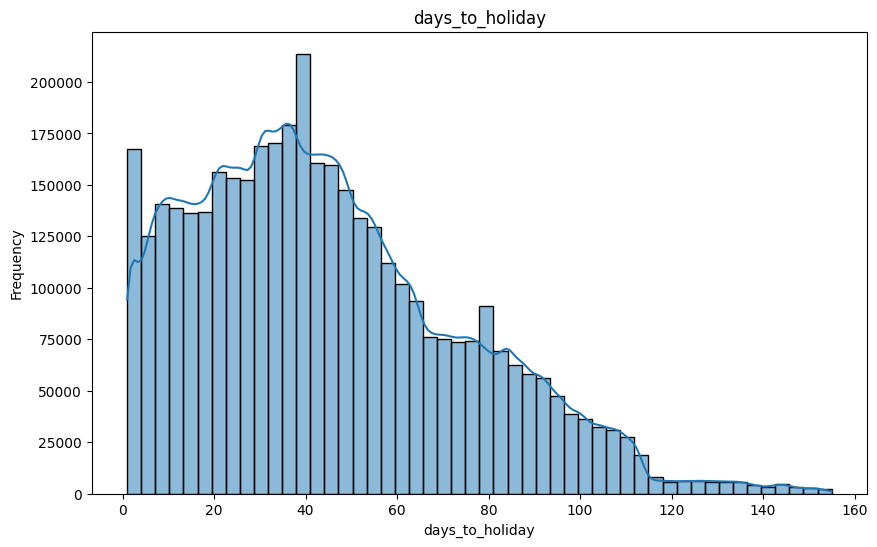

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(train['days_to_holiday'], bins=50, kde=True)
plt.title('days_to_holiday')
plt.xlabel('days_to_holiday')
plt.ylabel('Frequency')
plt.show()

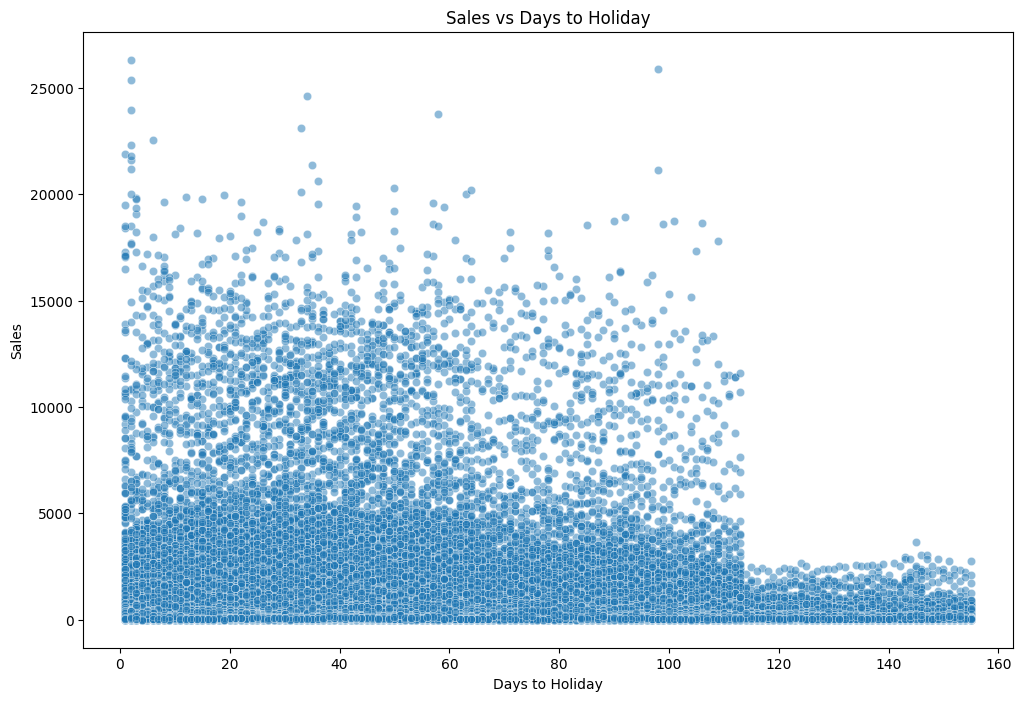

In [17]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='days_to_holiday', y='sales', alpha=0.5)
plt.title('Sales vs Days to Holiday')
plt.xlabel('Days to Holiday')
plt.ylabel('Sales')
plt.show()

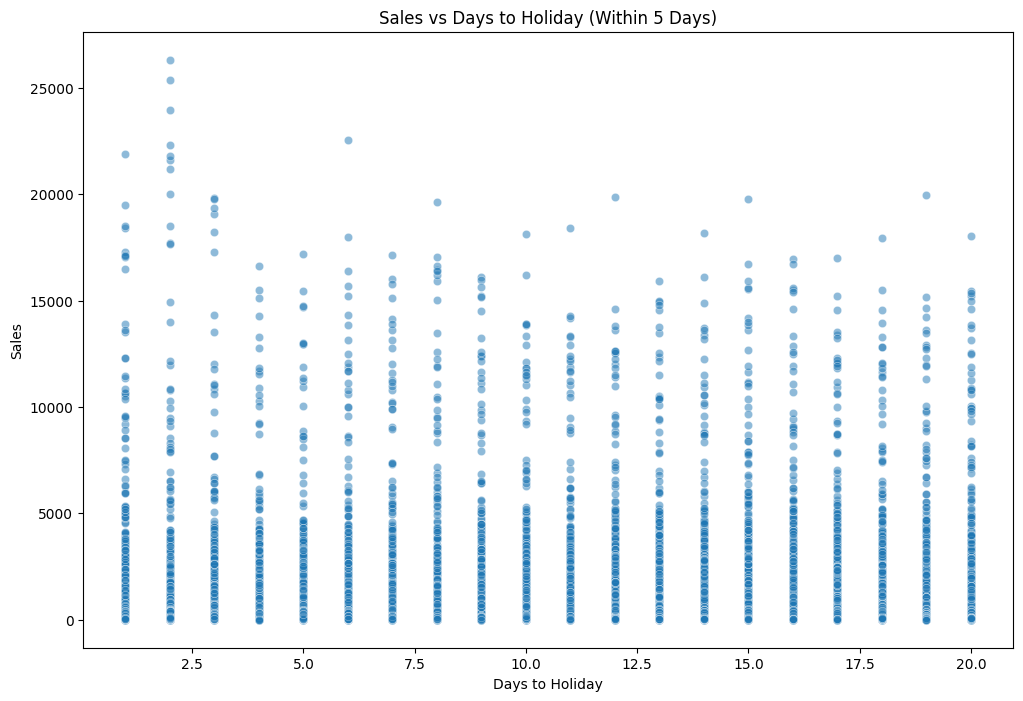

In [18]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train[train['days_to_holiday'] <= 20], x='days_to_holiday', y='sales', alpha=0.5)
plt.title('Sales vs Days to Holiday (Within 5 Days)')
plt.xlabel('Days to Holiday')
plt.ylabel('Sales')
plt.show()

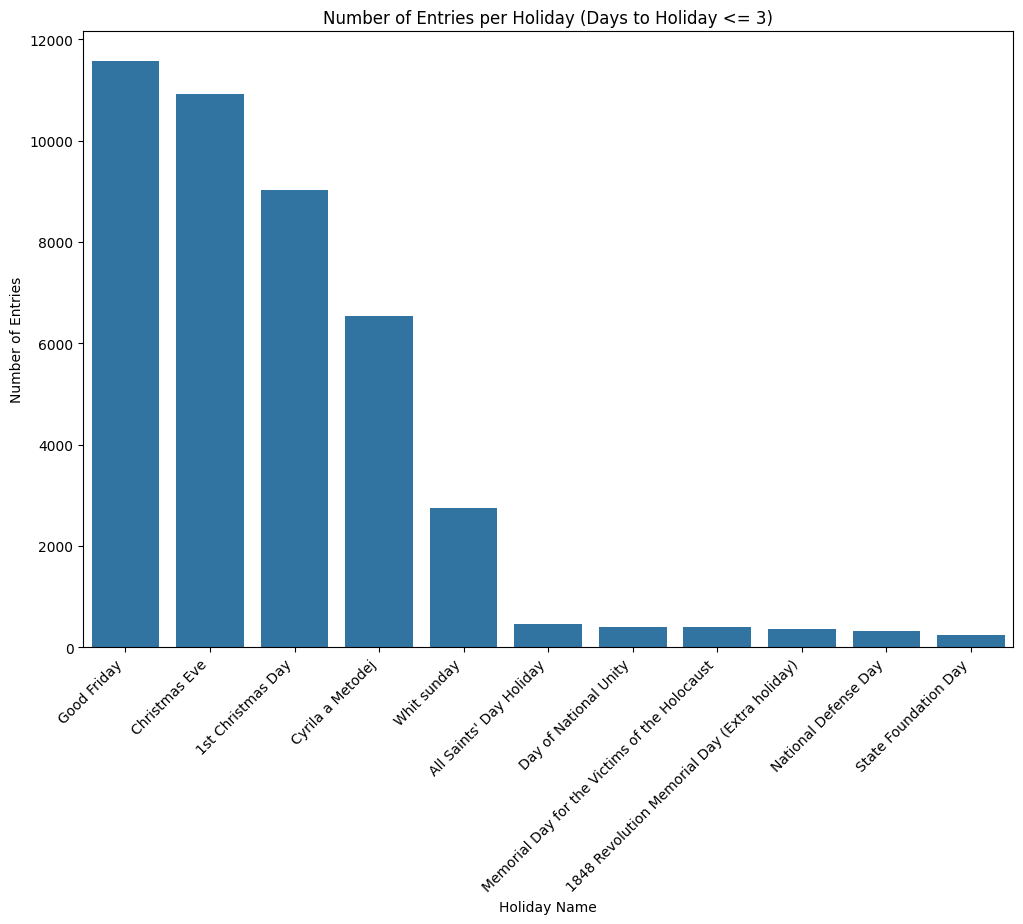

In [21]:
holiday_counts_3 = train[train['days_to_holiday'] <= 3]['holiday_name'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=holiday_counts_3.index.astype(str), y=holiday_counts_3.values)
plt.title('Number of Entries per Holiday (Days to Holiday <= 3)')
plt.xlabel('Holiday Name')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x='holiday_name', order=train['holiday_name'].value_counts().index)
plt.title('Number of Entries per Holiday')
plt.xlabel('Holiday Name')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train['days_to_shops_closed'], bins=50, kde=True)
plt.title('days_to_shops_closed')
plt.xlabel('days_to_shops_closed')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# day_after_closing 분포
plt.figure(figsize=(10, 6))
sns.barplot(x=calendar_extended['day_after_closing'].value_counts().index, 
            y=calendar_extended['day_after_closing'].value_counts().values)
plt.title('Distribution of Day After Closing')
plt.xlabel('Day After Closing')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()